In [ ]:
!pip install -q transformers datasets

     |████████████████████████████████| 5.8 MB 6.7 MB/s 
     |████████████████████████████████| 451 kB 78.3 MB/s 
     |████████████████████████████████| 182 kB 64.6 MB/s 
     |████████████████████████████████| 7.6 MB 52.4 MB/s 
     |████████████████████████████████| 212 kB 65.1 MB/s 
     |████████████████████████████████| 132 kB 63.1 MB/s 
     |████████████████████████████████| 127 kB 72.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import json
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from transformers import AutoTokenizer, TFAutoModel
from transformers import logging
logging.set_verbosity_error()  # skip warnings

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

clean = re.compile('<.*?>')
code_re = re.compile('<code>.*?<\/code>')


In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("pacovaldez/stackoverflow-questions-2016")

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/pacovaldez___parquet/pacovaldez--stackoverflow-questions-2016-4093bd52f522f19b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['title', 'body', 'label'],
        num_rows: 118778
    })
    test: Dataset({
        features: ['title', 'body', 'label'],
        num_rows: 118718
    })
    validation: Dataset({
        features: ['title', 'body', 'label'],
        num_rows: 59330
    })
})

In [ ]:
raw_datasets['test'][0]

{'title': 'How replace position++ code to make it Swift 3 compatible?',
 'body': "<p>I have following class, which has method <code>getNextToken</code> to iterate array items:</p>\n\n<pre><code>class Parser {\n    let tokens: [Token]\n    var position = 0\n\n    init(tokens: [Token]) {\n        self.tokens = tokens\n    }\n\n    func getNextToken() -&gt; Token? {\n        guard position &lt; tokens.count else {\n            return nil\n        }\n    return tokens[position++]\n    }\n}\n</code></pre>\n\n<p>but i have a warning message from compiler that ++ will be deprecated in Swift 3</p>\n\n<p>How should i rewrite my code to let method return array item at current position and increment position after that?</p>\n\n<p>Standard recommendations to add one more line <code>position +=1</code> doesn't fit here because i am exiting from the scope exactly when i am evaluating <code>tokens[position++]</code></p>",
 'label': 3}

In [ ]:
model_checkpoint = "bert-base-uncased"
batch_size = 8

In [ ]:
from transformers import AutoTokenizer, TFAutoModel


tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModel.from_pretrained(model_checkpoint)

tokenizer.add_tokens(['[CODE]'], special_tokens=True)

model.resize_token_embeddings(len(tokenizer)) 

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

In [ ]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    return re.sub(clean, '', text)

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('\n', ' ')
    sentence = sentence.replace('&quot;', '')
    sentence = sentence.replace(',', ' ')
    sentence = sentence.replace('(', ' ')
    sentence = sentence.replace(')', ' ')
    sentence = sentence.replace('*', ' ')
    sentence = sentence.replace('-', ' ')
    sentence = sentence.replace('_', ' ')
    sentence = sentence.replace('.', ' ')
    sentence = sentence.replace('?', ' ')
    sentence = sentence.replace('!', ' ')
    sentence = sentence.replace(';', ' ')
    sentence = sentence.replace('"', ' ')
    sentence = sentence.replace('\'', '')
    sentence = sentence.replace('$', ' ')
    sentence = sentence.replace('%', ' ')
    sentence = sentence.replace('}', ' ')
    sentence = sentence.replace('{', ' ')
    sentence = sentence.replace(':', ' ')
    sentence = sentence.replace('[', ' ')
    sentence = sentence.replace(']', ' ')
    return sentence

def postprocess(sentence):
    sentence = sentence.replace('/', ' ')
    sentence = sentence.replace('  ', ' ')
    sentence = sentence.replace('  ', ' ')
    return sentence

def replace_code_tag_token(text):
    """replace code tag with token"""
    text = text.replace('\n', ' ')  
    return re.sub(code_re, ' [CODE] ', text)



def merge_and_process_text(dataset):
  # dataset['body'] = ' ' + dataset['body']
  dataset['text'] = dataset['title'] + ' ' + dataset['body']
  dataset['text'] = preprocess(dataset['text'])
  dataset['text'] = replace_code_tag_token(dataset['text'])
  dataset['text'] = remove_html_tags(dataset['text'])
  dataset['text'] = postprocess(dataset['text'])
  dataset['text'] = dataset['text'][:600]
  return dataset

merge_and_process_text(raw_datasets['train'][0])

{'title': 'wso2 APIManager: Add PingIdentity as new OAuth-Endpoint',
 'body': '<p>We are planing to use PingFederate-Server as our central identity managment solution. What are the steps to integrate the ping server oauth-endpoint to our wso2 landscape.\nIs there already a solution available?</p>\n\n<p>I read the blog-post <a href="https://amilasnotes.wordpress.com/2015/05/19/integrating-with-a-third-party-oauth-provider-overview" rel="nofollow">https://amilasnotes.wordpress.com/2015/05/19/integrating-with-a-third-party-oauth-provider-overview</a> and it looks like that this task is possible.</p>\n\n<p>Has someone experienced replacing the internal wso2 key-manager?</p>\n\n<p>And is it possible to use both keymanagement solution (interal and ping), so that we don\'t need to migrate the current applications/access-tokens?</p>\n\n<p>Thx, in advance\nMarty</p>',
 'label': 3,
 'text': 'wso2 apimanager add pingidentity as new oauth endpoint we are planing to use pingfederate server as our c

In [ ]:

clean_dataset_test = raw_datasets['test'].shuffle(seed=42).map(merge_and_process_text)
clean_dataset_train = raw_datasets['train'].shuffle(seed=42).map(merge_and_process_text)
clean_dataset_validation = raw_datasets['validation'].shuffle(seed=42).map(merge_and_process_text)

  0%|          | 0/118718 [00:00<?, ?ex/s]

  0%|          | 0/118778 [00:00<?, ?ex/s]

  0%|          | 0/59330 [00:00<?, ?ex/s]

In [ ]:
max_length = 128


In [ ]:
cleantrain_encodings = tokenizer(clean_dataset_train['text'], truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
cleanvalid_encodings = tokenizer(clean_dataset_validation['text'], truncation=True, padding=True, max_length=max_length, return_tensors='tf')


In [ ]:
cleantest_encodings = tokenizer(clean_dataset_test['text'], truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
def build_model(bert_model, max_length, last_layer_num, drop_out=0.3):
    # Freeze all but layer_11 and pooler layers
    for w in bert_model.weights:
        if 'layer_._%d' % last_layer_num not in w.name:
            w._trainable = False

    input_ids = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='input_ids')
    attention_masks = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='attention_masks')
    token_type_ids = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='token_type_ids')
    
    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    cls_output = bert_output[0][:, 0, :]

    dropout_output = keras.layers.Dropout(drop_out)(cls_output)
    final_output = keras.layers.Dense(4, activation="softmax")(dropout_output)
    
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
cleantrain_encodings["input_ids"]

<tf.Tensor: shape=(118778, 128), dtype=int32, numpy=
array([[  101,  2129,  2000, ...,     0,     0,     0],
       [  101, 12849, 19646, ...,     0,     0,     0],
       [  101,  4531,  6263, ...,     0,     0,     0],
       ...,
       [  101, 10090, 18462, ...,     0,     0,     0],
       [  101,  1046, 11624, ...,  9078,  2099,   102],
       [  101,  2065,  3643, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
bert_model = build_model(
    model,
    max_length,
    11
)

In [ ]:
train_inputs = [
        cleantrain_encodings["input_ids"],
        cleantrain_encodings["attention_mask"],
        cleantrain_encodings["token_type_ids"]
    ]

valid_inputs = [
        cleanvalid_encodings["input_ids"],
        cleanvalid_encodings["attention_mask"],
        cleanvalid_encodings["token_type_ids"]
    ]

In [ ]:
bert_model.fit(
    train_inputs,
    np.array(clean_dataset_train['label']),
    validation_data=[valid_inputs, np.array(clean_dataset_validation['label'])],
    epochs=4,
)

Epoch 1/4


3712/3712 [==============================] - 1733s 465ms/step - loss: 1.3811 - accuracy: 0.2901 - val_loss: 1.3572 - val_accuracy: 0.3175
Epoch 2/4
3712/3712 [==============================] - 1721s 464ms/step - loss: 1.3624 - accuracy: 0.3140 - val_loss: 1.3526 - val_accuracy: 0.3214
Epoch 3/4
3712/3712 [==============================] - 1721s 464ms/step - loss: 1.3574 - accuracy: 0.3197 - val_loss: 1.3566 - val_accuracy: 0.3254
Epoch 4/4
3712/3712 [==============================] - 1719s 463ms/step - loss: 1.3536 - accuracy: 0.3250 - val_loss: 1.3431 - val_accuracy: 0.3349


In [ ]:
model_path = 'drive/MyDrive/ISchool/MIDS/W266/2022_Fall/notebooks/model_saves/bert_uncased_finetuned_2/model.h5'


In [ ]:
bert_model.save(model_path)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109483008   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:

# bert_model.load_weights(model_path)
# bert_model.summary()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = tf.math.confusion_matrix(y_true, y_pred)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    plt.figure(figsize=(20,7))
    sns.heatmap(
        cm, annot=True,
        xticklabels=label_names,
        yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

In [ ]:
valid_labels = np.array(clean_dataset_test['label'])
label_names = ['p0', 'p1', 'p2', 'p3']
y_probs = bert_model.predict(valid_inputs)


1855/1855 [==============================] - 506s 271ms/step


              precision    recall  f1-score   support

           0       0.34      0.66      0.44     14988
           1       0.35      0.00      0.01     14850
           2       0.29      0.26      0.28     14808
           3       0.37      0.41      0.39     14684

    accuracy                           0.33     59330
   macro avg       0.34      0.33      0.28     59330
weighted avg       0.34      0.33      0.28     59330



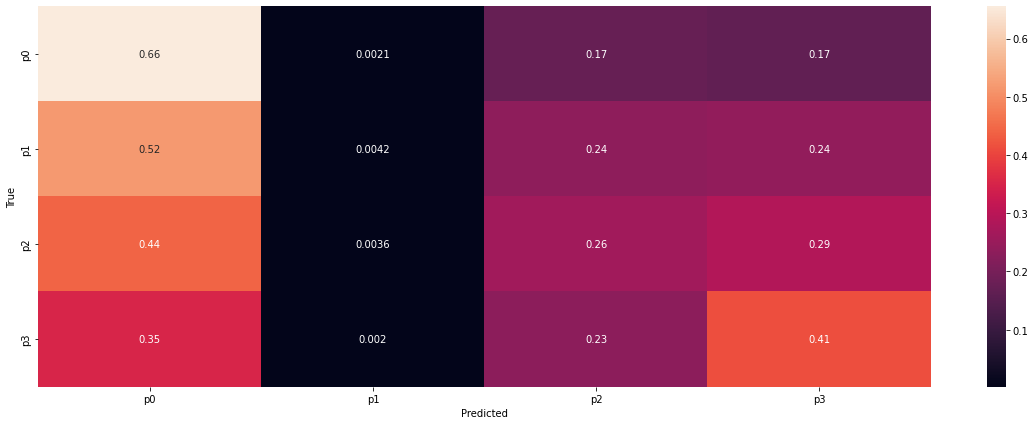

In [ ]:
y_pred = np.argmax(y_probs, axis=-1)
print(classification_report(valid_labels, y_pred))

plot_confusion_matrix(valid_labels, y_pred, label_names)

wrong_guesses = np.where(valid_labels != y_pred)

In [ ]:
text = np.array(clean_dataset_test['text'])
titles = np.array(clean_dataset_test['title'])
bodies = np.array(clean_dataset_test['body'])

In [ ]:
for i in wrong_guesses[0][:5]:
    print('-'*50)
    print(titles[i])
    print('+'*10)
    print(bodies[i])
    print('+'*10)
    print(text[i])
    print('+'*10)
    print(valid_labels[i])
    print(y_pred[i])

--------------------------------------------------
How do I list my gists?
++++++++++
<p>Can I get a listing of my gists?</p>

<p>Such a listing would list all gists, not only four and not show the contents of a gist until I click it.</p>
++++++++++
how do i list my gists can i get a listing of my gists such a listing would list all gists not only four and not show the contents of a gist until i click it 
++++++++++
1
0
--------------------------------------------------
Vuex getter not updating
++++++++++
<p>I have the below getter:</p>
<pre class="lang-js prettyprint-override"><code>    withEarmarks: state =&gt; {
        var count = 0;
        for (let l of state.laptops) {
            if (l.earmarks.length &gt; 0) {
                count++;
            }
        }
      return count;
    }
</code></pre>
<p>And in a component, this computed property derived from that getter:</p>
<pre class="lang-js prettyprint-override"><code>        withEarmarks() { return this.$store.getters.withEa

In [ ]:
wrong_guesses[0][1]

1

In [ ]:
np.unique(valid_labels)

array([0, 1, 2, 3])

In [ ]:
np.bincount(y_pred)

array([29276,   176, 13432, 16446])

In [ ]:
y_pred[0]

0